In [1]:
# Reference: https://www.tensorflow.org/datasets/keras_example

%load_ext tensorboard

from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os


# hyperparameters
batch_size = 128

# other
logging_dir = './logs/part3/'

try:
    os.remove(logging_dir)
    print("Removed previous logs")
except:
    print("No previous logs")


No previous logs


## Create input pipeline

### Load a dataset

In [58]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


### Build a training pipeline

In [59]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32` and reshape."""
    norm_img = tf.cast(image, tf.float32) / 255.
    return tf.reshape(norm_img, [28, 28]), tf.keras.utils.to_categorical(label, 10)

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

In [61]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Model and Training

In [111]:
from keras.models import Sequential
from keras.layers import Input, Reshape, SimpleRNN, LSTM, GRU, Dense

n_units = 70

model = Sequential()
model.add(Input(shape=(28, 28)))
model.add(SimpleRNN(n_units, activation='relu'))
#model.add(LSTM(n_units, activation='relu'))
#model.add(GRU(n_units, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_23 (SimpleRNN)            │ (None, 70)                  │           6,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │             710 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,640 (29.84 KB)

 Trainable params: 7,640 (29.84 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
epochs = 15
lr = 0.001 # Higher is worse
beta_1 = 0.9 # 0.9 # Dont really matter can use 0.5
beta_2 = 0.999 # 0.999 # Lower learns slower

tensorboard_callback = TensorBoard(log_dir=logging_dir, histogram_freq=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)#, beta_1=beta_1, beta_2=beta_2) 
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy']) # Try sparse cross entropy
history = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[tensorboard_callback])

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5771 - loss: 1.1875 - val_accuracy: 0.8865 - val_loss: 0.3676
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9087 - loss: 0.3072 - val_accuracy: 0.9413 - val_loss: 0.2005
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9347 - loss: 0.2207 - val_accuracy: 0.9443 - val_loss: 0.1873
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9446 - loss: 0.1892 - val_accuracy: 0.9534 - val_loss: 0.1576
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9501 - loss: 0.1721 - val_accuracy: 0.9447 - val_loss: 0.1858
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9533 - loss: 0.1587 - val_accuracy: 0.9577 - val_loss: 0.1398
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9588 - loss: 0.1402 - val_accuracy: 0.9613 - val_loss: 0.1225
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9618 - loss: 0.1262 - val_accuracy: 0.

Text(0.5, 0.98, '70 Unit RNN')

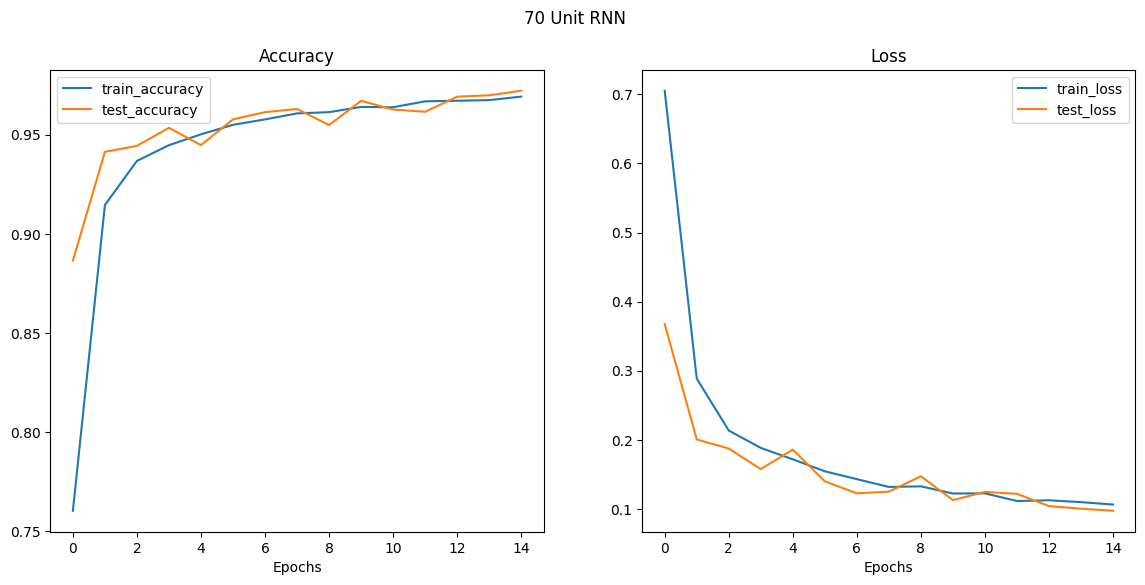

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
axs[0].plot(history.history['accuracy'], label='train_accuracy')
axs[0].plot(history.history['val_accuracy'], label='test_accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='train_loss')
axs[1].plot(history.history['val_loss'], label='test_loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

fig.suptitle('{} Unit RNN'.format(n_units))

Text(0.5, 0.98, '28 Unit LSTM')

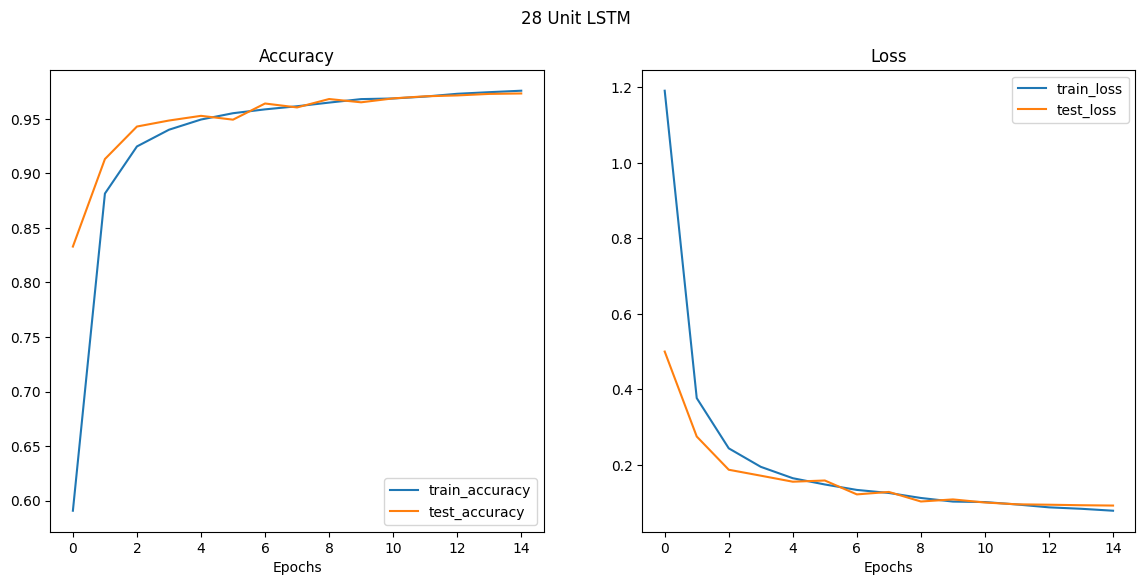

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
axs[0].plot(history.history['accuracy'], label='train_accuracy')
axs[0].plot(history.history['val_accuracy'], label='test_accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='train_loss')
axs[1].plot(history.history['val_loss'], label='test_loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

fig.suptitle('{} Unit LSTM'.format(n_units))

Text(0.5, 0.98, '28 Unit GRU')

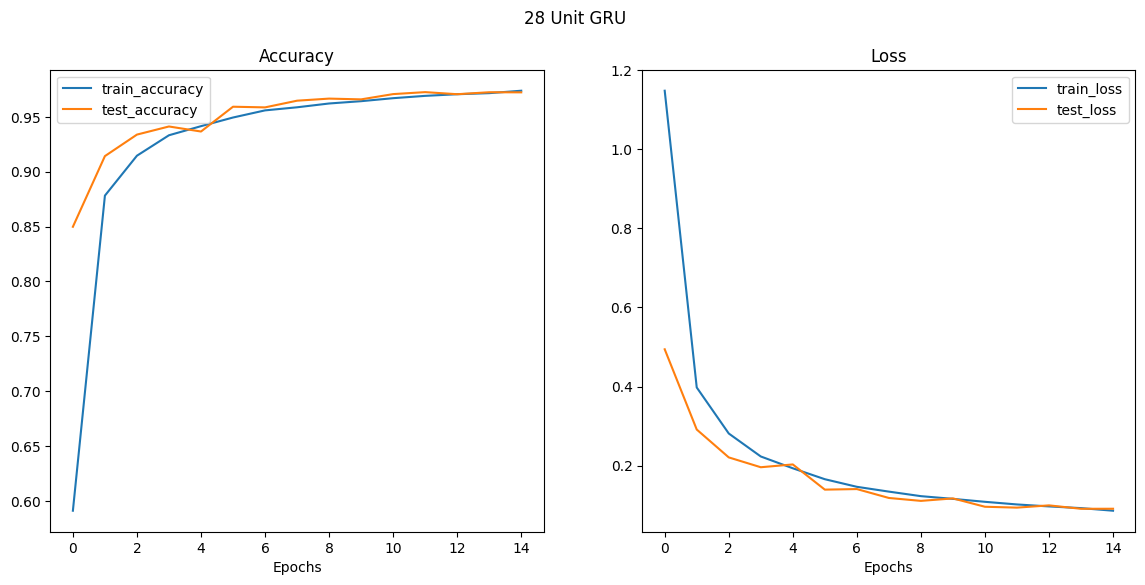

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
axs[0].plot(history.history['accuracy'], label='train_accuracy')
axs[0].plot(history.history['val_accuracy'], label='test_accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='train_loss')
axs[1].plot(history.history['val_loss'], label='test_loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

fig.suptitle('{} Unit GRU'.format(n_units))

### Comparison with CNN

In [114]:
from keras.models import Sequential
from keras.layers import Input, Rescaling, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,111,946 (4.24 MB)

 Trainable params: 1,111,946 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
conv_layer = model.get_layer('conv2d_1')
conv_layer.output

<KerasTensor shape=(None, 8, 8, 64), dtype=float32, sparse=False, name=keras_tensor_142>

In [119]:
epochs = 15
lr = 0.001 # Higher is worse
beta_1 = 0.9 # 0.9 # Dont really matter can use 0.5
beta_2 = 0.999 # 0.999 # Lower learns slower

tensorboard_callback = TensorBoard(log_dir=logging_dir, histogram_freq=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)#, beta_1=beta_1, beta_2=beta_2) 
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy']) # Try sparse cross entropy
history = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[tensorboard_callback])

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8895 - loss: 0.3678 - val_accuracy: 0.9843 - val_loss: 0.0482
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9875 - loss: 0.0425 - val_accuracy: 0.9888 - val_loss: 0.0321
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9921 - loss: 0.0244 - val_accuracy: 0.9922 - val_loss: 0.0260
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9943 - loss: 0.0178 - val_accuracy: 0.9904 - val_loss: 0.0281
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9957 - loss: 0.0141 - val_accuracy: 0.9890 - val_loss: 0.0351
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9964 - loss: 0.0110 - val_accuracy: 0.9910 - val_loss: 0.0276
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9967 - loss: 0.0095 - val_accuracy: 0.9922 - val_loss: 0.0252
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9975 - loss: 0.0084 - 

Text(0.5, 0.98, 'CNN')

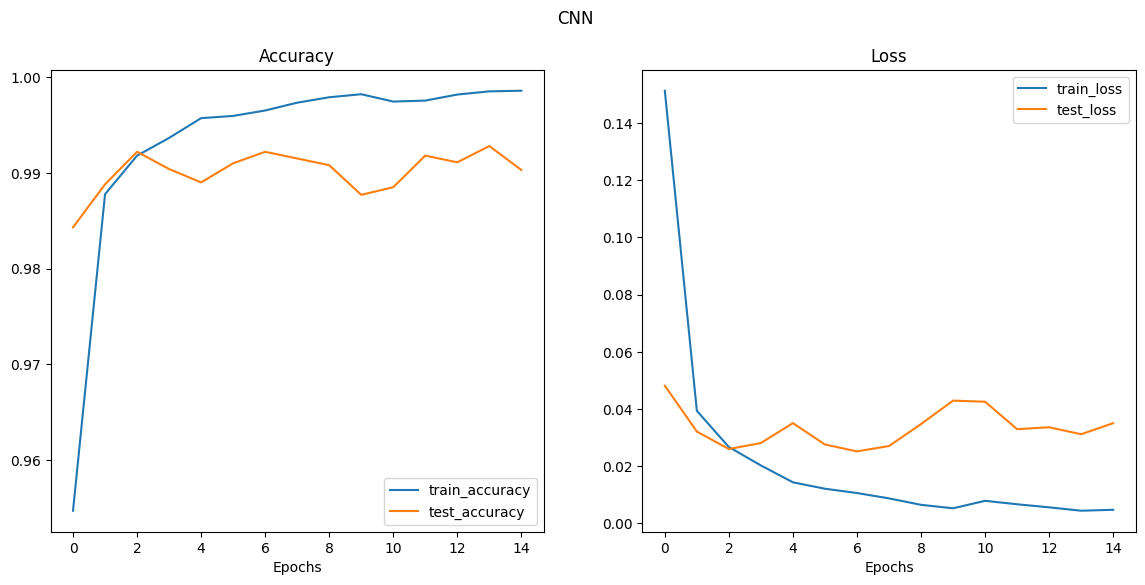

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
axs[0].plot(history.history['accuracy'], label='train_accuracy')
axs[0].plot(history.history['val_accuracy'], label='test_accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

# Loss
axs[1].plot(history.history['loss'], label='train_loss')
axs[1].plot(history.history['val_loss'], label='test_loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

fig.suptitle('CNN')